In [4]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

In [5]:
print(grid.columns)

Index(['F_l_0', 'F_l_1', 'F_l_2', 'O1_l_0', 'O1_l_1', 'O1_l_2', 'O2_l_0',
       'O2_l_1', 'O2_l_2', 'O3_l_0', 'O3_l_1', 'O3_l_2', 'O4_l_0', 'O4_l_1',
       'O4_l_2', 'O5_l_0', 'O5_l_1', 'O5_l_2', 'O6_l_0', 'O6_l_1', 'O6_l_2',
       'O7_l_0', 'O7_l_1', 'O7_l_2', 'O8_l_0', 'O8_l_1', 'O8_l_2', 'O9_l_0',
       'O9_l_1', 'O9_l_2', 'delta_nu'],
      dtype='object')


In [6]:
# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)


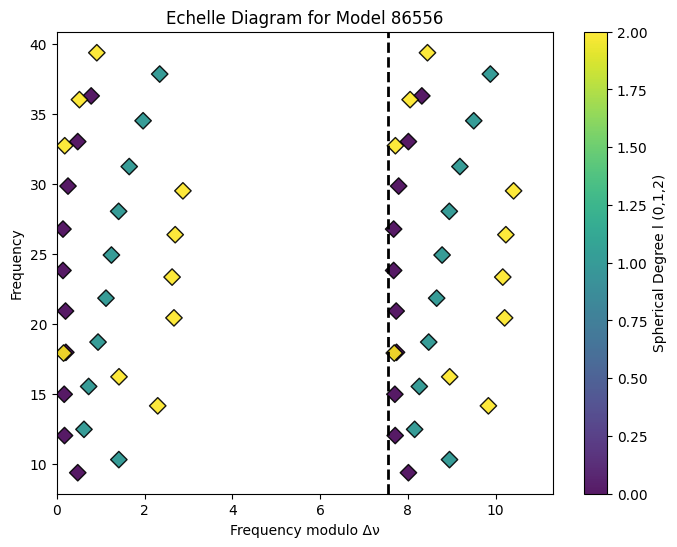

In [6]:
# again this is just for fun and to see that we can still plot the echelle diagrams

ii = np.random.randint(0, 153314)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sc = ax.scatter(X[ii, :, 1], X[ii, :, 0], marker='D', c=y[ii], cmap="viridis", edgecolors='black', alpha=0.9, s=70)
ax.scatter(X[ii, :, 1] + grid.loc[ii, 'delta_nu'], X[ii, :, 0], marker='D', c=y[ii], cmap="viridis", edgecolors='black', alpha=0.9, s=70)
ax.axvline(grid.loc[ii, 'delta_nu'], color='black', linestyle='--', linewidth=2)
ax.set_xlim(0, grid.loc[ii, 'delta_nu']*1.5)
plt.colorbar(sc, label="Spherical Degree l (0,1,2)")
plt.xlabel("Frequency modulo Δν")
plt.ylabel("Frequency")
plt.title(f"Echelle Diagram for Model {ii}")

plt.show()

In [7]:
from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])


In [8]:
size = 10000 # or for all models it would be: X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

torch.Size([10000, 30, 2])


# NEW

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=3, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()

        a = 5 # 5 # for non periodic 1, 3, 5

        nfeat = 128 # 128

        # Separate convolution for freq and nu mod delta nu
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)


        # network has to see that for example 0.01 and 0.96 are close to each other in circular space
        # but why kernel size 3? this means that the convolution considers neighbourhood of 3 adjacent values -> current point, left and right

        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=2)

        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

    def forward(self, x, plot=False):
        # x shape: [batch_size, num_points, 2]
        batch_size, num_points, _ = x.shape # torch.Size([B, 30, 2])
        # Split channels and reshape to [batch_size, 1, num_points]
        x_freq = x[:, :, 0].unsqueeze(1)      # torch.Size([B, 1, 30])
        x_modnu = x[:, :, 1].unsqueeze(1)     # torch.Size([B, 1, 30])

        # circular padding to the periodic input (pad 1 on each side for kernel_size=3)
        x_freq = F.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = F.pad(x_modnu, (1, 1), mode='circular')

        # convolutions as before
        x_freq_feat = self.conv_1_a(x_freq)       # [B, 64, N]
        x_modnu_feat = self.conv_1_b(x_modnu)     # [B, 64, N]
        print(x_freq_feat.shape)
        # Combine features from both channels
        x = x_freq_feat + x_modnu_feat

        # Apply batch norm + relu + next conv
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))

        x = nn.MaxPool1d(num_points)(x)  # [B, 64, 1]
        x = x.view(batch_size, -1)       # [B, 64]

        return x
        
class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(point_dimension=point_dimension)

        nhidden = 16 # 64
        nfeat = 128 # 128
        
        # Per-point classification layers
        self.fc_1 = nn.Linear(nfeat+2, nhidden)
        self.fc_2 = nn.Linear(nhidden, 3)

    def forward(self, x):
        global_features = self.base_pointnet(x)  # shape: [batch_size, 64]
        global_features = global_features.unsqueeze(1)  # shape: [batch_size, 1, 64]
        global_features = global_features.repeat(1, x.shape[1], 1)  # [batch_size, num_points, 66]
        # 66 comes from 2 coordinates so to speak the the 64 global feature elements.
        x = torch.cat((x, global_features), dim=2)  # x is [batch_size, num_points, 2]
        
        # need to paste the global features after the individual points as inputs for the segmentation (classification each point in the cloud)
        x = F.relu(self.fc_1(x)) 

        return F.log_softmax(self.fc_2(x), dim=2)

## Trying smth out with the delta nu correction!

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=3, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()

        a = 3
        nfeat = 64

        # Separate convolutions for frequency and mod-nu
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=2)

        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

        # Learnable correction layer: maps per-point frequency to a correction (shared across batch)
        self.delta_nu_correction = nn.Sequential(
            nn.Linear(1, 1),  # from frequency to correction
            #nn.Tanh()         # bound correction between -1 and 1 (will scale later)
        )

    def forward(self, x, delta_nu=1.0, plot=False):
        # x shape: [batch_size, num_points, 2]
        batch_size, num_points, _ = x.shape
        freqs = x[:, :, 0].unsqueeze(2)  # [B, N, 1]

        # Predict a correction for each point, then take the mean over the batch
        delta_corr = self.delta_nu_correction(freqs)  # [B, N, 1]
        delta_corr = delta_corr.mean(dim=1, keepdim=True)  # [B, 1, 1]
        scaled_corr = delta_corr * 0.1 * delta_nu  # Scale: max ±10% of delta_nu

        effective_dnu = delta_nu + scaled_corr  # [B, 1, 1]

        # Compute modulo-nu using the corrected delta_nu
        mod_nu = (freqs % effective_dnu) / effective_dnu  # normalize between 0 and 1
        mod_nu = mod_nu.squeeze(2)  # [B, N]

        # Now reshape inputs for convs
        x_freq = freqs.squeeze(2).unsqueeze(1)  # [B, 1, N]
        x_modnu = mod_nu.unsqueeze(1)          # [B, 1, N]

        # Pad
        x_freq = F.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = F.pad(x_modnu, (1, 1), mode='circular')

        # Conv feature extraction
        x_freq_feat = self.conv_1_a(x_freq)
        x_modnu_feat = self.conv_1_b(x_modnu)

        x = x_freq_feat + x_modnu_feat
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(batch_size, -1)

        if plot:
            #return x, scaled_corr.squeeze(dim=-1)
            return x, scaled_corr.squeeze()
        return x

class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(point_dimension=point_dimension)

        nhidden = 64 # 64
        nfeat = 64 # 128
        
        # Per-point classification layers
        self.fc_1 = nn.Linear(nfeat+2, nhidden)
        self.fc_2 = nn.Linear(nhidden, 3)

    def forward(self, x, delta_nu=1.0, return_corr=False):
        if return_corr:
            global_features, dnu_corr = self.base_pointnet(x, delta_nu=delta_nu, plot=True)
        else:
            global_features = self.base_pointnet(x, delta_nu=delta_nu, plot=False)

        global_features = global_features.unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2)
        x = F.relu(self.fc_1(x))
        output = F.log_softmax(self.fc_2(x), dim=2)

        if return_corr:
            return output, dnu_corr
        return output

In [10]:
print(np.exp(-0.45))

0.6376281516217733


In [11]:
m = nn.Tanh()
input = torch.randn(2)
output = m(input)
print(output)

tensor([ 0.0306, -0.9558])


In [12]:
model = SegmentationPointNet(num_classes=3, point_dimension=2)
loss = nn.NLLLoss()

In [13]:
out = model(inpt)

In [14]:
history_train, history_test = [], []
Nepoch = 80
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean")  # Standard per-point loss

target_test = y_train[:size]
target = y_train[:size]
inpt_test = inpt

for epoch in range(Nepoch):
    for i in range(nbatches):
        optimizer.zero_grad()

        # define new data
        new_inpt, new_target = Dropper(inpt[i*batch_size:(i+1)*batch_size], 
                                       target[i*batch_size:(i+1)*batch_size])
        
        
        # Forward pass
        seg_output = model(inpt[i*batch_size:(i+1)*batch_size])
        
        # Compute loss
        cost = loss_fn(
            seg_output.permute(0, 2, 1), 
            target[i*batch_size:(i+1)*batch_size]
        )
        
        # Backward pass
        cost.backward()
        optimizer.step()

    # Evaluation on full training set (used as test here)
    seg_out_test = model(inpt_test)
    cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    #print(model.base_pointnet.delta_nu_correction[0].weight.grad)


    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

tensor([[-0.0012]])
Epoch 0: Train Loss = 1.0019, Test Loss = 0.9944
tensor([[0.0007]])
Epoch 1: Train Loss = 0.9490, Test Loss = 0.9369
tensor([[-0.0004]])
Epoch 2: Train Loss = 0.9135, Test Loss = 0.9023
tensor([[0.0008]])
Epoch 3: Train Loss = 0.8830, Test Loss = 0.8716
tensor([[-0.0035]])
Epoch 4: Train Loss = 0.8614, Test Loss = 0.8473
tensor([[0.0249]])
Epoch 5: Train Loss = 0.8380, Test Loss = 0.8294
tensor([[-0.0098]])
Epoch 6: Train Loss = 0.8101, Test Loss = 0.8054
tensor([[-0.0024]])
Epoch 7: Train Loss = 0.7905, Test Loss = 0.7859
tensor([[0.0790]])
Epoch 8: Train Loss = 0.7770, Test Loss = 0.7683
tensor([[0.1839]])
Epoch 9: Train Loss = 0.7559, Test Loss = 0.7524
tensor([[0.2181]])
Epoch 10: Train Loss = 0.7331, Test Loss = 0.7246
tensor([[0.1197]])
Epoch 11: Train Loss = 0.7109, Test Loss = 0.7030
tensor([[0.0422]])
Epoch 12: Train Loss = 0.7000, Test Loss = 0.6831
tensor([[0.4614]])
Epoch 13: Train Loss = 0.6877, Test Loss = 0.6729
tensor([[0.1464]])
Epoch 14: Train Loss

In [18]:
import torch.nn.functional as F

# Pick a sample
sample_id = torch.randint(0, inpt.shape[0], (1,)).item()
x_sample = inpt[sample_id].unsqueeze(0)         # shape: [1, N, 2]
y_sample = y_train[sample_id].unsqueeze(0)      # shape: [1, N]
true_dnu = 1.0  # or whatever Δν you passed

# Run through model to get prediction and correction
with torch.no_grad():
    output_corr, dnu_corr = model(x_sample, delta_nu=true_dnu, return_corr=True)
    output_uncorr = model(x_sample, delta_nu=true_dnu, return_corr=False)

# Convert log-probabilities to softmax
probs_corr = torch.exp(output_corr.squeeze(0))      # [N, C]
probs_uncorr = torch.exp(output_uncorr.squeeze(0))  # [N, C]

# Compute confidence = max probability per point
conf_corr = probs_corr.max(dim=1).values.mean().item()
conf_uncorr = probs_uncorr.max(dim=1).values.mean().item()

print(f"Δν correction made: {dnu_corr.item():.4f}")
print(f"Avg confidence without correction: {conf_uncorr:.4f}")
print(f"Avg confidence with correction:    {conf_corr:.4f}")

Δν correction made: -1.9374
Avg confidence without correction: 0.8832
Avg confidence with correction:    0.8832


-1.9374440908432007


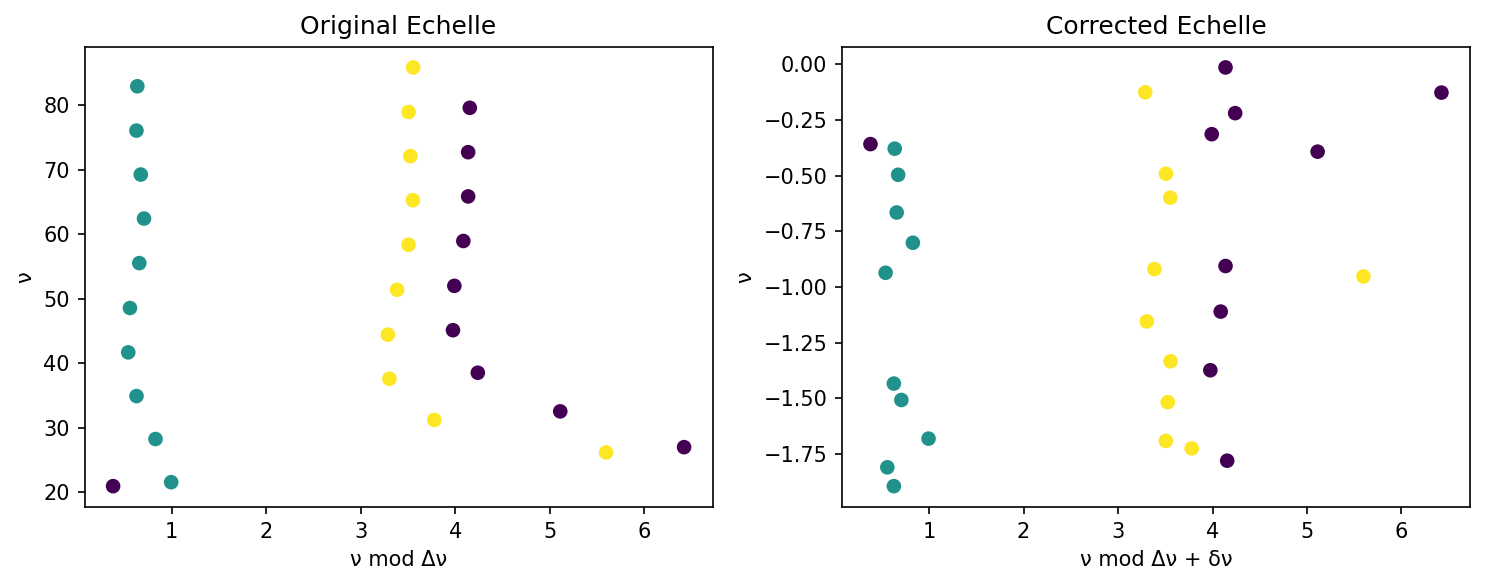

In [20]:
import matplotlib.pyplot as plt

i_data=np.random.randint(0,size)

freqs = inpt.detach().numpy()[i_data, :, 1]
mod_uncorr = inpt.detach().numpy()[i_data, :, 0] 
mod_corr = inpt.detach().numpy()[i_data, :, 0] % (dnu_corr.item())
print(dnu_corr.item())
plt.figure(figsize=(10, 4), dpi=150)
plt.subplot(1, 2, 1)
plt.title("Original Echelle")
plt.scatter(freqs, mod_uncorr, c=y_sample[0].numpy(), cmap='viridis')
plt.xlabel("ν mod Δν"); plt.ylabel("ν")

plt.subplot(1, 2, 2)
plt.title("Corrected Echelle")
plt.scatter(freqs, mod_corr, c=y_sample[0].numpy(), cmap='viridis')
plt.xlabel("ν mod Δν + δν"); plt.ylabel("ν")

plt.tight_layout()
plt.show()

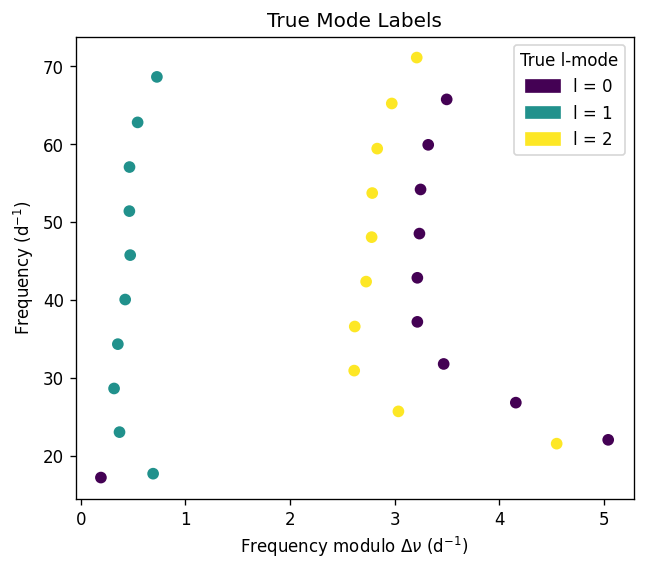

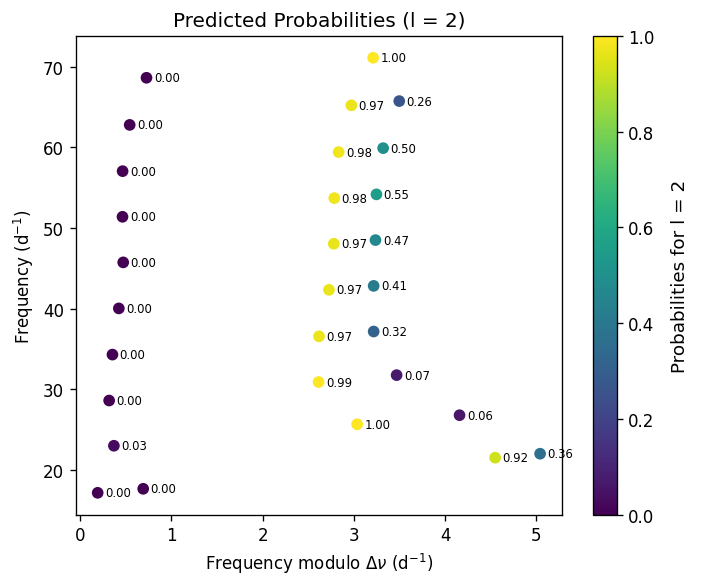

In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
i_data = 50
l = 2  # which mode (l=0,1,2) to plot probability for

# Get the data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = seg_out_test.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels with custom legend ===
fig1 = plt.figure(figsize=(6, 5), dpi=120)
plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="True l-mode", loc="upper right")
plt.title("True Mode Labels")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")

# === Second figure: Predicted probability for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=7, color="black", ha='left', va='center')

cbar = plt.colorbar(sc)
cbar.set_label(f"Probabilities for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

In [56]:
print(seg_out_test.shape)

torch.Size([10000, 30, 3])


In [57]:
loss_fn = nn.NLLLoss()
loss = loss_fn(seg_out_test.transpose(2,1), y_train[:size])

In [58]:
print(loss)

tensor(0.3786, grad_fn=<NllLoss2DBackward0>)


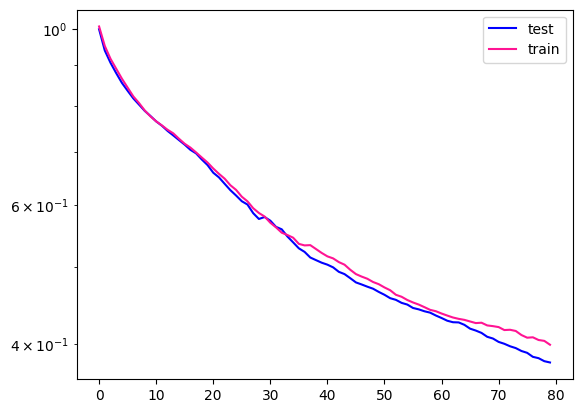

In [59]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()